In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%cd drive/My Drive

/content/drive/My Drive


In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
import tensorflow as tf
from tensorflow.keras.utils import get_custom_objects
from tensorflow.keras.layers import Activation
from tensorflow.keras import layers
train = pd.read_csv('data/train.csv',index_col='id')
test = pd.read_csv('data/test.csv',index_col='id')
train_digit = train['digit']
train.drop('digit', axis=1, inplace=True)
train1 = pd.concat([train, test], axis=0)

In [31]:
from tensorflow.keras import backend as K
class mish(Activation):
    def __init__(self, activation, **kwargs):
        super(mish, self).__init__(activation, **kwargs)
        self.__name__ = 'mish'

def Mish(x):
    return x*K.tanh(K.softplus(x))

get_custom_objects().update({'mish': mish(Mish)}) 

In [32]:
column_number = {}

for i in range(26):
  column_number[chr(65+i)] = i

def to_number(x, dic):
    return dic[x]

train1['letter_num'] = train1['letter'].apply(lambda x: to_number(x, column_number))
train1.drop('letter', axis=1, inplace =True)

In [33]:
from tensorflow.keras.utils import to_categorical

train_img = train1.iloc[:,1:].to_numpy().reshape(-1,28,28,1)
train_letter = train1['letter_num']

features = train_img/255.0
labels = to_categorical(train_letter,num_classes=26)

from sklearn.model_selection import train_test_split

validation_split = 0.15

X_train, X_val, y_train, y_val = train_test_split(features, labels, test_size = validation_split, random_state = 100)

In [34]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
        rotation_range = 10,
        width_shift_range = 3,
        height_shift_range = 3,
        zoom_range=0.2,
        )

flow1=train_datagen.flow(X_train,y_train,batch_size=16,seed=2020) 
test_datagen = ImageDataGenerator()
flow2=test_datagen.flow(X_val,y_val,batch_size=16,seed=2020) 


In [23]:
def createFolder(directory):
    
    import os
    
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except:
        print("Error: Falied creating directory" + directory)

def plot_curve(epochs, hist, list_of_metrics):
    
    fig, ax = plt.subplots(1,2,figsize = (12, 8))
    
    for i in range(len(ax)):
        ax[i].set_xlabel('Epochs')
        ax[i].set_ylabel('Value')
        
        for n in range(len(list_of_metrics)):
            if i == 0:
                y = hist[list_of_metrics[n]]
                ax[i].plot(epochs, y)
                ax[i].set_title('Loss')
                if n == 1:
                    break
            else:
                if n >= 2:
                    y = hist[list_of_metrics[n]]
                    ax[i].plot(epochs, y)
                    ax[i].set_title('Accuracy')
                    
    plt.show()

In [40]:
def create_cnn(learning_rate):
    
    # Remove the previous model.
    model = None
    
    # Input layer
    img_input = layers.Input(shape = (28,28,1))

    # Identity mapping shortcut을 위한 conv_1 layer
    conv_1 = layers.BatchNormalization()(img_input)
    conv_1 = layers.Activation('mish')(conv_1)
    conv_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',)(conv_1) 
    
    conv_2_1 = layers.BatchNormalization()(conv_1)
    conv_2_1 = layers.Activation('mish')(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_1)
    conv_2_1 = layers.Dropout(rate = 0.3)(conv_2_1)
    conv_2_1 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_1)
    
    # ShortCut connection
    add_2_1 = layers.add([conv_1, conv_2_1])
    out_2_1 = layers.Activation('mish')(add_2_1)
    
    conv_2_2 = layers.BatchNormalization()(out_2_1)
    conv_2_2 = layers.Activation('mish')(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same')(conv_2_2)
    conv_2_2 = layers.Dropout(rate = 0.3)(conv_2_2)
    conv_2_2 = layers.Conv2D(128, kernel_size = 3, padding = 'same',activation = 'mish')(conv_2_2)
    
    # ShortCut connection
    add_2_2 = layers.add([out_2_1, conv_2_2])
    out_2_2 = layers.Activation('mish')(add_2_1)
    
    pool_2 = layers.MaxPool2D((2,2), strides = 2)(out_2_2)
    
    conv_3_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_2)

    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_1)
    
    # ShortCut connection
    add_3_1 = layers.add([conv_3_0, conv_3_1])
    out_3_1 = layers.Activation('mish')(add_3_1)
    
    conv_3_1 = layers.BatchNormalization()(conv_3_0)
    conv_3_1 = layers.Activation('mish')(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_3_1)
    conv_3_1 = layers.Dropout(rate = 0.3)(conv_3_1)
    conv_3_2 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_3_2)
    
    # ShortCut connection
    add_3_2 = layers.add([out_3_1, conv_3_2])
    out_3_2 = layers.Activation('relu')(add_3_2)
    
    pool_3 = layers.MaxPool2D((2,2), strides = 2)(out_3_2)
    
    conv_4_0 = layers.Conv2D(256, kernel_size = 1, strides = 1)(pool_3)
    
    conv_4_1 = layers.BatchNormalization()(conv_4_0)
    conv_4_1 = layers.Activation('mish')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same')(conv_4_1)
    conv_4_1 = layers.Conv2D(256, kernel_size = 3, padding = 'same',activation = 'mish')(conv_4_1)
    
    # ShortCut connection
    add_4_1 = layers.add([conv_4_0, conv_4_1])
    out_4_1 = layers.Activation('mish')(add_4_1)
    
    pool_4 = layers.MaxPool2D((2,2), strides = 2)(out_4_1)

    conv_5_0 = layers.Conv2D(512, kernel_size = 1, strides = 1)(pool_4)
    
    conv_5_1 = layers.BatchNormalization()(conv_5_0)
    conv_5_1 = layers.Activation('mish')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same')(conv_5_1)
    conv_5_1 = layers.Conv2D(512, kernel_size = 3, padding = 'same',activation = 'mish')(conv_5_1)
    
    # ShortCut connection
    add_5_1 = layers.add([conv_5_0, conv_5_1])
    out_5_1 = layers.Activation('mish')(add_5_1)
    
    # FC layers
    img_features = layers.Flatten()(out_5_1)
    img_features = layers.BatchNormalization()(img_features)
    img_features = layers.Dense(1024, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(512, activation = 'mish')(img_features)
    img_features = layers.Dropout(rate = 0.3)(img_features)
    img_features = layers.Dense(256, activation = 'mish')(img_features)
    # Output layer
    digit_pred = layers.Dense(26, activation = 'softmax')(img_features)
    
    model = tf.keras.Model(inputs = img_input, outputs = digit_pred)
    
    model.compile(optimizer = tf.keras.optimizers.Adam(lr = learning_rate),
                 loss = 'categorical_crossentropy',
                 metrics = ['accuracy'])
                    
    return model


def train_model_v1(model, train, test , epochs, batch_size = None, validation_split = 0.1):
    
    early_stop = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy', patience = 10, restore_best_weights = True)
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor = 0.5, patience = 3, min_lr = 3e-5)
    
    history = model.fit(train, epochs = epochs, batch_size = batch_size,
                       shuffle = True, validation_data = test, callbacks = [early_stop, reduce_lr])
    
    epochs = history.epoch
    hist = pd.DataFrame(history.history)
    
    return epochs, hist


In [41]:
model_list = []

for i in range(10):
    model = create_cnn(learning_rate = 0.0003)
    model_list.append(model)

***************Trainig_my_model_0*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4587 - accuracy: 0.8534 - val_loss: 0.4849 - val_accuracy: 0.8485
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4455 - accuracy: 0.8517 - val_loss: 0.2645 - val_accuracy: 0.9107
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4036 - accuracy: 0.8659 - val_loss: 0.3250 - val_accuracy: 0.8947
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.3878 - accuracy: 0.8695 - val_loss: 0.2624 - val_accuracy: 0.9133
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.3711 - accuracy: 0.8809 - val_loss: 0.2166 - val_accuracy: 0.9257
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.3727 - accuracy: 0.8769 - val_loss: 0.2494 - val_accuracy: 0.9157
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

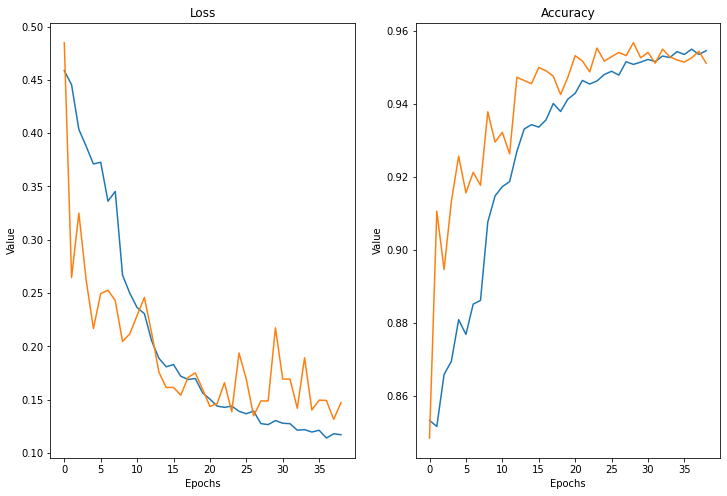

***************Trainig_my_model_1*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.4727 - accuracy: 0.5645 - val_loss: 0.5558 - val_accuracy: 0.8112
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.8170 - accuracy: 0.7439 - val_loss: 0.5132 - val_accuracy: 0.8331
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6525 - accuracy: 0.7926 - val_loss: 0.5385 - val_accuracy: 0.8272
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5794 - accuracy: 0.8144 - val_loss: 0.5790 - val_accuracy: 0.8234
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5350 - accuracy: 0.8250 - val_loss: 0.3484 - val_accuracy: 0.8834
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4930 - accuracy: 0.8400 - val_loss: 0.3447 - val_accuracy: 0.8870
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

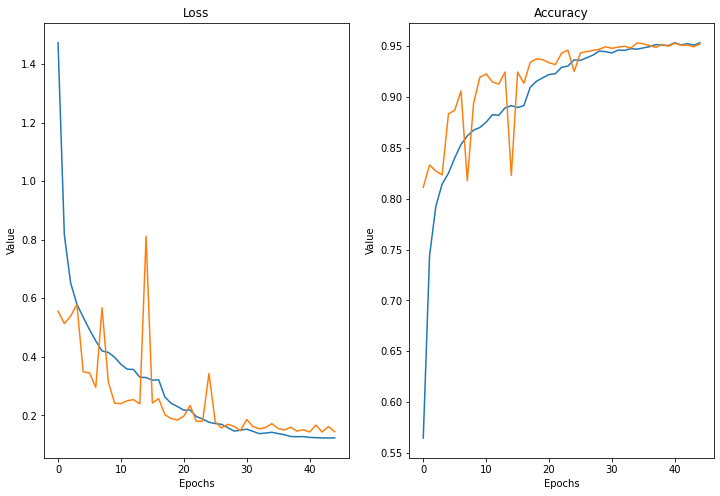

***************Trainig_my_model_2*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.4824 - accuracy: 0.5632 - val_loss: 0.6679 - val_accuracy: 0.7873
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.7998 - accuracy: 0.7464 - val_loss: 0.4354 - val_accuracy: 0.8615
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6660 - accuracy: 0.7901 - val_loss: 0.4013 - val_accuracy: 0.8675
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5756 - accuracy: 0.8149 - val_loss: 0.6170 - val_accuracy: 0.7941
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5162 - accuracy: 0.8359 - val_loss: 0.3148 - val_accuracy: 0.8988
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4868 - accuracy: 0.8415 - val_loss: 0.3430 - val_accuracy: 0.8917
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

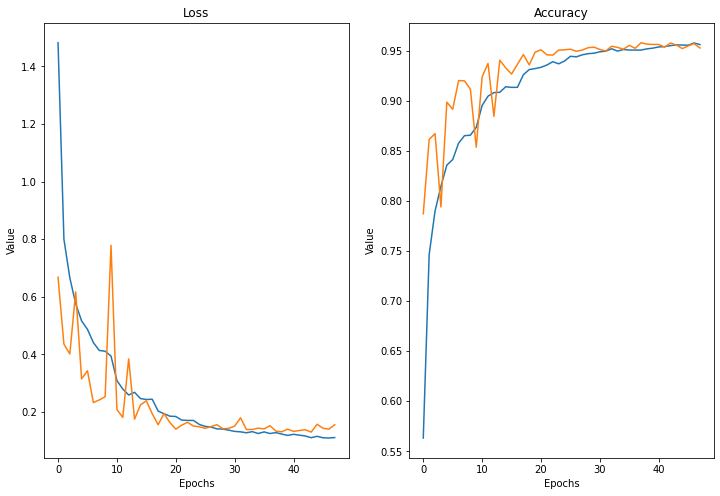

***************Trainig_my_model_3*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.5095 - accuracy: 0.5543 - val_loss: 0.8911 - val_accuracy: 0.7305
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.7938 - accuracy: 0.7537 - val_loss: 0.6689 - val_accuracy: 0.7876
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6419 - accuracy: 0.7943 - val_loss: 0.3564 - val_accuracy: 0.8840
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5707 - accuracy: 0.8190 - val_loss: 0.3593 - val_accuracy: 0.8763
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5079 - accuracy: 0.8338 - val_loss: 0.3444 - val_accuracy: 0.8796
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4650 - accuracy: 0.8517 - val_loss: 0.2768 - val_accuracy: 0.9065
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

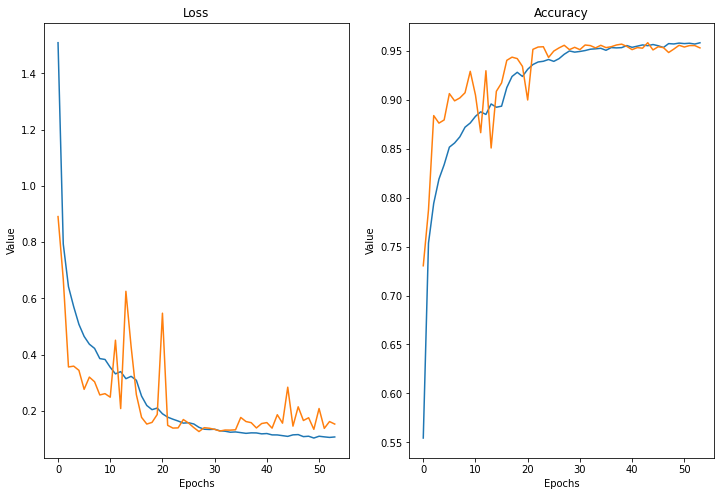

***************Trainig_my_model_4*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.5083 - accuracy: 0.5520 - val_loss: 0.7548 - val_accuracy: 0.7651
Epoch 2/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.8225 - accuracy: 0.7427 - val_loss: 0.5869 - val_accuracy: 0.8127
Epoch 3/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.6770 - accuracy: 0.7853 - val_loss: 0.4549 - val_accuracy: 0.8447
Epoch 4/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.6020 - accuracy: 0.8070 - val_loss: 0.4385 - val_accuracy: 0.8642
Epoch 5/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.5297 - accuracy: 0.8291 - val_loss: 0.3112 - val_accuracy: 0.8941
Epoch 6/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.4699 - accuracy: 0.8464 - val_loss: 0.3343 - val_accuracy: 0.8905
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

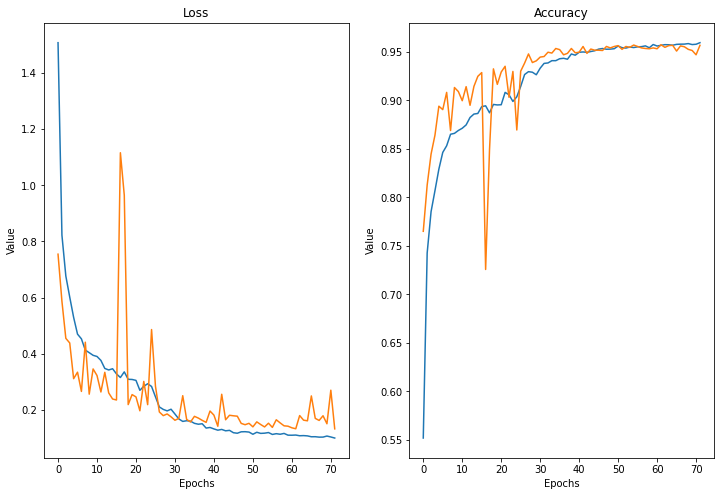

***************Trainig_my_model_5*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.4991 - accuracy: 0.5603 - val_loss: 0.6162 - val_accuracy: 0.8024
Epoch 2/200
1197/1197 [==============================] - 17s 15ms/step - loss: 0.8125 - accuracy: 0.7468 - val_loss: 0.4996 - val_accuracy: 0.8364
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6850 - accuracy: 0.7849 - val_loss: 0.3663 - val_accuracy: 0.8769
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6047 - accuracy: 0.8036 - val_loss: 0.4080 - val_accuracy: 0.8746
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5300 - accuracy: 0.8279 - val_loss: 0.3257 - val_accuracy: 0.8891
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4799 - accuracy: 0.8441 - val_loss: 0.2541 - val_accuracy: 0.9166
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

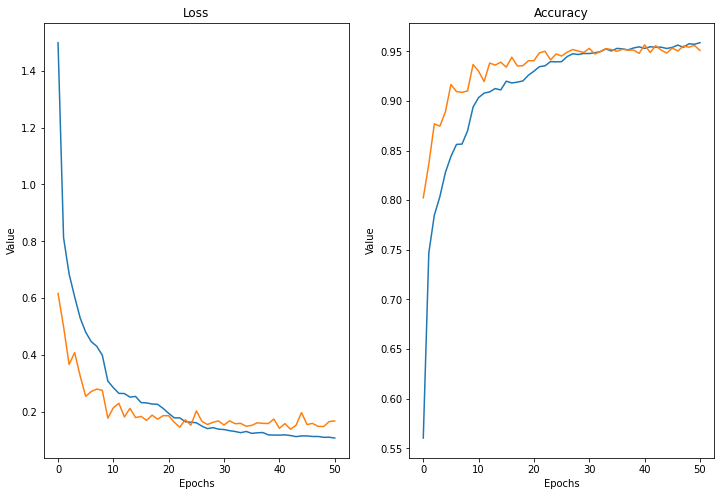

***************Trainig_my_model_6*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.5011 - accuracy: 0.5547 - val_loss: 0.6576 - val_accuracy: 0.7834
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.8125 - accuracy: 0.7478 - val_loss: 0.3831 - val_accuracy: 0.8808
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6820 - accuracy: 0.7877 - val_loss: 0.3681 - val_accuracy: 0.8728
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5915 - accuracy: 0.8100 - val_loss: 0.3403 - val_accuracy: 0.8911
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5360 - accuracy: 0.8272 - val_loss: 1.1742 - val_accuracy: 0.6707
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5084 - accuracy: 0.8335 - val_loss: 0.4092 - val_accuracy: 0.8719
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

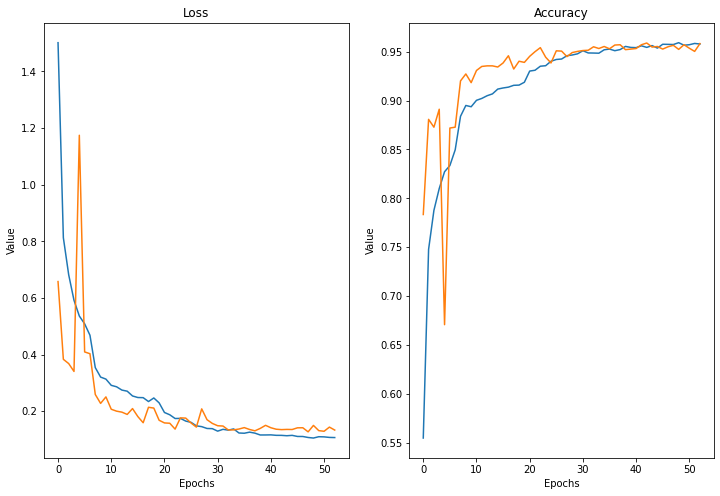

***************Trainig_my_model_7*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.4554 - accuracy: 0.5671 - val_loss: 0.5392 - val_accuracy: 0.8172
Epoch 2/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.7952 - accuracy: 0.7493 - val_loss: 0.4268 - val_accuracy: 0.8630
Epoch 3/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.6610 - accuracy: 0.7916 - val_loss: 0.4244 - val_accuracy: 0.8615
Epoch 4/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5785 - accuracy: 0.8147 - val_loss: 0.4613 - val_accuracy: 0.8612
Epoch 5/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.5225 - accuracy: 0.8326 - val_loss: 0.3089 - val_accuracy: 0.9015
Epoch 6/200
1197/1197 [==============================] - 17s 14ms/step - loss: 0.4853 - accuracy: 0.8432 - val_loss: 0.3005 - val_accuracy: 0.9021
Epoch 7/200
1197/1197 [==============================] - 17s 14ms/s

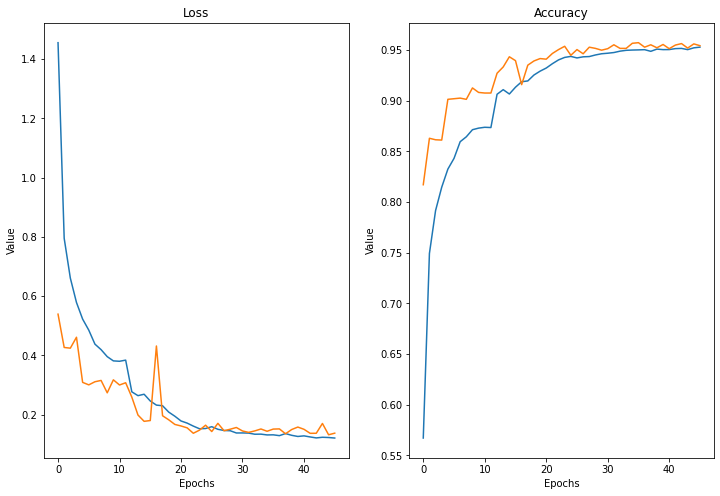

***************Trainig_my_model_8*****************
Epoch 1/200
1197/1197 [==============================] - 17s 14ms/step - loss: 1.5146 - accuracy: 0.5539 - val_loss: 0.5525 - val_accuracy: 0.8157
Epoch 2/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.8225 - accuracy: 0.7423 - val_loss: 0.5833 - val_accuracy: 0.8157
Epoch 3/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.6825 - accuracy: 0.7855 - val_loss: 0.6374 - val_accuracy: 0.8216
Epoch 4/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.5885 - accuracy: 0.8137 - val_loss: 0.4788 - val_accuracy: 0.8379
Epoch 5/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.5130 - accuracy: 0.8327 - val_loss: 0.4110 - val_accuracy: 0.8713
Epoch 6/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.4776 - accuracy: 0.8443 - val_loss: 0.3126 - val_accuracy: 0.8988
Epoch 7/200
1197/1197 [==============================] - 16s 14ms/s

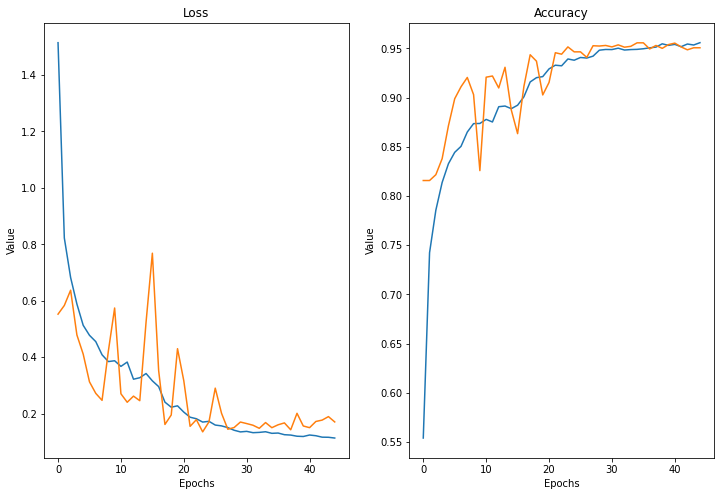

***************Trainig_my_model_9*****************
Epoch 1/200
1197/1197 [==============================] - 16s 14ms/step - loss: 1.4974 - accuracy: 0.5559 - val_loss: 0.5274 - val_accuracy: 0.8237
Epoch 2/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.8395 - accuracy: 0.7341 - val_loss: 0.4823 - val_accuracy: 0.8420
Epoch 3/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.6745 - accuracy: 0.7857 - val_loss: 0.3598 - val_accuracy: 0.8864
Epoch 4/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.5952 - accuracy: 0.8142 - val_loss: 0.5004 - val_accuracy: 0.8370
Epoch 5/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.5281 - accuracy: 0.8289 - val_loss: 0.3544 - val_accuracy: 0.8822
Epoch 6/200
1197/1197 [==============================] - 16s 14ms/step - loss: 0.4922 - accuracy: 0.8394 - val_loss: 0.5761 - val_accuracy: 0.8621
Epoch 7/200
1197/1197 [==============================] - 16s 14ms/s

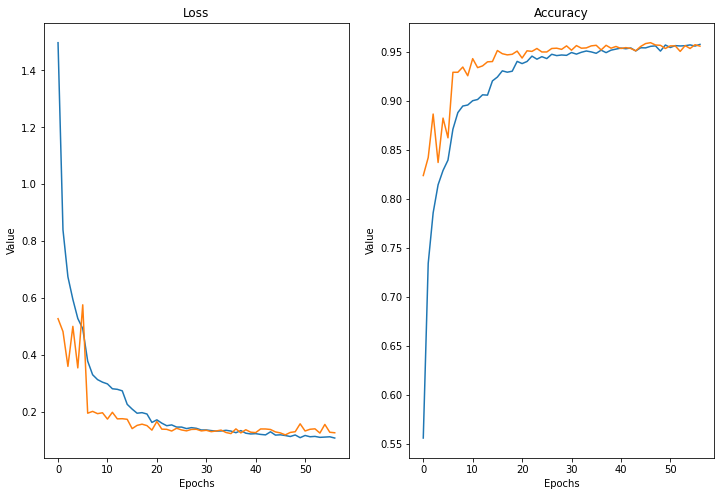

In [43]:
epochs = 200
batch_size = 64
validation_split = 0.2

for i in range(len(model_list)):
    print("***************Trainig_my_model_{}*****************".format(i))
    epoch, hist = train_model_v1(model_list[i], flow1, flow2, epochs, batch_size) 

    # Plot a graph of the metric vs. epochs.
    list_of_metrics_to_plot = ['loss','val_loss','accuracy','val_accuracy']
    plot_curve(epoch, hist, list_of_metrics_to_plot)

In [44]:
result_list = []

for i in range(len(model_list)):
    print("************************Evaluating_my_model_{}************************".format(i))
    result = model_list[i].evaluate(flow2)
    result_list.append(result)

************************Evaluating_my_model_0************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1487 - accuracy: 0.9568
************************Evaluating_my_model_1************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1715 - accuracy: 0.9533
************************Evaluating_my_model_2************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1335 - accuracy: 0.9583
************************Evaluating_my_model_3************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1565 - accuracy: 0.9586
************************Evaluating_my_model_4************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1328 - accuracy: 0.9574
************************Evaluating_my_model_5************************
212/212 [==============================] - 1s 5ms/step - loss: 0.1414 - accuracy: 0.9565
************************Evaluating_my_model_6*